<h1>IW Fall 2016 - Bitcoin, Blockchains, and Smart Contracts</h1>
<h3>
Eric Mitchell  
Advised by Arvind Narayanan  
Collaboration from Nick Butler, Martin Cherkes, Jianqing Fan, Omid Abrishamchian
</h3>
<h3>Notes</h3>
<p>
Bid/ask spreads from OKCoin:  
http://data.bitcoinity.org/markets/spread/5y/USD?c=e&f=m10&r=week&st=log&t=l

<h4>Summary:</h4>
Mid-late 2014:  
OKC bid/ask % on [.1,.3], vol (M, monthly) on [1, 6]
  
Mid 2016:  
OKC bid/ask % on [.025, .035], vol (M, monthly) on [20, 35]
<h4>Edge Behavior</h4>
Weird accuracy/profit artifacts at edges of domain of gamma threshold
</p>

<h2>Tunable parameters to the model:</h2>
α: exponential smoothing factor  
{θ}: price change threshold under which no change is considered to have occurred  
γ: minimum confidence threshold to act on predictions  
d: number of minutes in the past to look at for feature generation

In [1]:
# parameters
ALPHA = 0.0
THETA = 0.0
VTHETA = 0.0
BTHETA = 0.000
GAMMA = 0.7
D = 15
N = 1500000
T_0 = 20000
TRADE_SIZE = 1
BID_ASK = .0002

<h2>Load the data from the CSV</h2>

In [2]:
# LOAD DATA

%matplotlib inline

import json
import pandas as pd
import numpy as np
import math

df = pd.read_csv('data_cleaned.csv', parse_dates=['Date'])[T_0:T_0+N+1]
df['Smoothed'] = df['Price']
df

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


,Error,Date,Minute,Price,Delta,Beta,Volume,Smoothed
20000,0,2014-04-14,268,2732.719,-0.78,-0.016843,65.82,2732.719
20001,0,2014-04-14,269,2731.689,-2.22,-0.026398,29.84,2731.689
20002,0,2014-04-14,270,2729.329,-2.11,-0.022159,94.70,2729.329
20003,0,2014-04-14,271,2728.957,-0.18,0.007928,63.73,2728.957
20004,0,2014-04-14,272,2733.523,6.55,0.090518,122.58,2733.523
20005,0,2014-04-14,273,2738.086,3.97,0.059814,70.67,2738.086
20006,0,2014-04-14,274,2743.438,4.95,0.068297,118.25,2743.438
20007,0,2014-04-14,275,2749.744,12.42,0.221179,118.96,2749.744
20008,0,2014-04-14,276,2769.170,20.16,0.421539,193.22,2769.170
20009,0,2014-04-14,277,2780.310,-2.60,-0.102998,194.09,2780.310


<h1>Smooth the prices</h1>
<p>We use exponential smoothing with:
p[t] = alpha \* p[t-1] + (1 - alpha) \* p[t]
</p>

In [387]:
# SMOOTH PRICES

smoothed_price = np.empty([len(df)])
last = -1
idx = 0

for val in df['Price']:
    if last < 0:
        last = val
    
    smooth = ALPHA * last + (1-ALPHA) * val
    smoothed_price[idx] = smooth
    last = smooth
    idx += 1

df.loc[:,'Smoothed'] = pd.Series(smoothed_price, index=df.index)

In [388]:
# CALCULATE PRICE AND VOLUME DIFFERENCES
df.loc[:,'Diff'] = df['Price'].diff()
df.loc[:,'SDiff'] = df['Smoothed'].diff()
df.loc[:,'VDiff'] = df['Volume'].diff()

# GENERATE PRICE DIFFERENCE SIGN FLAGS
df.loc[abs(df['Diff']) <= THETA, 'Sign'] = 1
df.loc[df['Diff'] > THETA, 'Sign'] = 2
df.loc[df['Diff'] < -THETA, 'Sign'] = 0

df.loc[abs(df['SDiff']) <= THETA, 'SSign'] = 1
df.loc[df['SDiff'] > THETA, 'SSign'] = 2
df.loc[df['SDiff'] < -THETA, 'SSign'] = 0

df.loc[abs(df['VDiff']) <= VTHETA, 'VSign'] = 1
df.loc[df['VDiff'] > VTHETA, 'VSign'] = 2
df.loc[df['VDiff'] < -VTHETA, 'VSign'] = 0

df.loc[abs(df['Beta']) <= BTHETA, 'BSign'] = 1
df.loc[df['Beta'] > BTHETA, 'BSign'] = 2
df.loc[df['Beta'] < -BTHETA, 'BSign'] = 0

# DROP FIRST VALUE BECAUSE IT HAS NaN DIFF
df = df.tail(N)

1500001
1500000


In [389]:
# helpers to generate features according to the thing

def last(data, t):
    return data[t-1]

def tally(data, d, t):
    sigma_values = [0, 1, 2]
    counts = [0 for i in range(len(d) * len(sigma_values))]
    for j, sigma_val in enumerate(sigma_values):
        for k, d_val in enumerate(d):
            for i in range(-1, -(d_val + 1), -1):
                if int(data[t+i]) == sigma_val:
                    counts[j * len(d) + k] += 1
    
    return counts

def longest_run(data, t):
    l = int(last(data, t))
    run_length = 0
    idx = -2
    while int(data[idx]) == l:
        run_length += 1
        idx -= 1
    
    features = [0, 0, 0]
    features[l] = run_length
    
    return features

def beta(beta_sigmas, t):
    return beta_sigmas[t-1]

# VARIABILITY OF PROFIT CURVE IF VOLUME IS OMITTED
def features(price_sigmas, volume_sigmas, beta_sigmas, t):
#     d_values = list(range(1, D))
    d_values = [D]
    return np.array(
                    [beta(beta_sigmas, t)] +
                    [last(price_sigmas, t)] + 
                    [last(volume_sigmas, t)] + 
                    tally(price_sigmas, d_values, t) +
                    longest_run(price_sigmas, t)
                   )

In [390]:
# GENERATE THE FEATURES
targets = np.array([int(val) for val in df['Sign'].values])

n = len(df)
train_proportion = 0.8

train_len = int((n-D) * train_proportion)
test_start = train_len + D

prices = df['Price'].values
p_sigmas = df['SSign'].values
v_sigmas = df['VSign'].values
b_sigmas = df['BSign'].values
trainf = np.array([features(p_sigmas, v_sigmas, b_sigmas, t) for t in range(D + 1, train_len)])
testf = np.array([features(p_sigmas, v_sigmas, b_sigmas, t) for t in range(test_start, n)])
traint = list(targets[D + 1:train_len])
testt = list(targets[test_start:n])

In [391]:
from sklearn.ensemble import RandomForestClassifier

# CREATE A RANDOM FOREST, TRAIN WITH PART OR SO OF THE DATA
rf = RandomForestClassifier()
rf.fit(trainf, traint)

# SPIT OUT THE CLASS AND CORRESPONDING PROBABILITIES
predictions = rf.predict(testf)
proba = rf.predict_proba(testf)

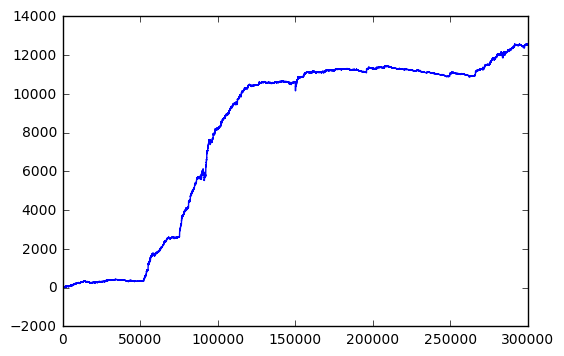

In [392]:
correct = 0
guesses = 0
position_btc = False
position_yuan = 0
max_investment = 0

profit_status = []

for idx, pred in enumerate(predictions):
    conf = max(proba[idx])
    if predictions[idx] != 1 and conf > GAMMA:
        guesses += 1
        if pred == testt[idx]:
            correct += 1

        if predictions[idx] == 2:
            if not position_btc:
                position_btc = True
                position_yuan -= TRADE_SIZE * prices[test_start + idx-1]
                
                position_yuan -= (BID_ASK * prices[test_start + idx-1]) / 2
                if -position_yuan > max_investment:
                    max_investment = -position_yuan
        else:
            if position_btc:
                position_btc = False
                position_yuan += TRADE_SIZE * prices[test_start + idx-1]
                
                position_yuan -= (BID_ASK * prices[test_start + idx-1]) / 2
        
        
    profit_status.append(position_yuan + (TRADE_SIZE * prices[test_start + idx-1] if position_btc else 0))
# print(profit_status)
plt.plot(profit_status)
# plt.plot(prices[int(len(prices) * train_proportion):])

In [393]:
# ANALYZE RESPONSE TO CHANGES IN GAMMA

# a small helper function for fractional range()
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

correct_proportions = []
gammas = []
actionable_proportions = []
guess_counts = []
profits = []
end_positions = []
investments = []

for gamma in frange(.5, 1, .004):
    correct = 0
    guesses = 0
    position_btc, position_yuan = 0, 0
    max_investment = 0
    
    for idx, pred in enumerate(predictions):
        conf = max(proba[idx])
        if predictions[idx] != 1 and conf > gamma:
            guesses += 1
            if pred == testt[idx]:
                correct += 1
            
            if predictions[idx] == 2:
                if not position_btc:
                    position_btc = True
                    position_yuan -= TRADE_SIZE * prices[test_start + idx-1]

                    position_yuan -= (BID_ASK * prices[test_start + idx-1]) / 2
                    if -position_yuan > max_investment:
                        max_investment = -position_yuan
            else:
                if position_btc:
                    position_btc = False
                    position_yuan += TRADE_SIZE * prices[test_start + idx-1]

                    position_yuan -= (BID_ASK * prices[test_start + idx-1]) / 2
    
    if guesses != 0:
        correct_proportions.append(correct/float(guesses))
        gammas.append(gamma)
        actionable_proportions.append(guesses/float(len(predictions)))
        guess_counts.append(guesses)
    else:
        correct_proportions.append(0)
        gammas.append(gamma)
        actionable_proportions.append(guesses/float(len(predictions)))
        guess_counts.append(guesses)
    
    end_positions.append((position_btc, position_yuan))
    profits.append(position_yuan + (TRADE_SIZE * prices[idx] if position_btc else 0))
    investments.append(max_investment)
    
returns = [profit/investment for profit, investment in zip(profits, investments)]

In [ ]:
# print('gamma\tacc\tact\tguesses\tpi  \tbtc\tyuan')

gamma_series = pd.Series(gammas, name='Gamma')
correct_series = pd.Series(correct_proportions, name='Accuracy')
action_series = pd.Series(actionable_proportions, name='Actionability')
guesses_series = pd.Series(guess_counts, name='Attempts')
profit_series = pd.Series(profits, name='Profit')
btc_series = pd.Series([a[0] for a in end_positions], name='BTC Position')
yuan_series = pd.Series([a[1] for a in end_positions], name='Yuan Position')
returns_series = pd.Series(returns, name='Returns')

output = pd.DataFrame(
                        zip(
                            correct_series, 
                            action_series, 
                            guesses_series, 
                            profit_series, 
                            btc_series,
                            yuan_series,
                            returns_series
                         ),
                        columns=[
                               correct_series.name, 
                               action_series.name, 
                               guesses_series.name, 
                               profit_series.name,
                               btc_series.name,
                               yuan_series.name,
                               returns_series.name
                              ],
                        index=gamma_series
                     )
pd.set_option('display.max_rows', len(output))
output

# for gamma, c, a, g, p, pos in zip(gammas, correct_proportions, 
#                                   actionable_proportions, guess_counts, 
#                                   profits, end_positions):
#     print(str(round(gamma, 4)) 
#           + '\t' + str(round(c, 4)) 
#           + ' \t' + str(round(a, 4)) 
#           + ' \t' + str(g) 
#           + ' \t' + str(int(p))
#           + '  \t' + str(pos[0]) 
#           + ' \t' + str(int(pos[1]))
#          )

In [ ]:
# WHY CAN WE EXCLUDE THE VALUES WITH INFINITE SLOPE
import matplotlib.pyplot as plt

plt.plot(gammas, profits) # SPIKE IN MIDDLE
# plt.plot(gammas, correct_proportions) # SIGMOID
# plt.plot(gammas, returns) # TWO-LEVEL SHELF, SPIKE IN MIDDLE
# plt.plot(gammas, actionable_proportions) # INVERTED SIGMOID

# plt.scatter(correct_proportions, profits, s=1) # INVERTED PARABOLA
# plt.scatter([a[0] for a in end_positions], returns, s=1) # FLAT

# df.iloc[[0]]
# df.iloc[[-1]]

In [ ]:
# from pybrain.structure import RecurrentNetwork
# from pybrain.structure import FullConnection
# from pybrain.structure import LinearLayer, SigmoidLayer
# from pybrain.tools.shortcuts import buildNetwork
# from pybrain.structure.modules import SoftmaxLayer, LSTMLayer
# from pybrain.supervised.trainers import BackpropTrainer
# from pybrain.datasets.supervised import SupervisedDataSet


# targets_v = np.zeros([len(df), 3])

# for idx, sign in enumerate(targets):
#     if not np.isnan(sign):
#         targets_v[idx, int(sign)] = 1

# dp = df['SDiff'].values
# dp_sign = targets_v


# all_data = [(np.array(dp[i:i+D]), dp_sign[i+D]) for i in range(n-D)]
# train_d = [(np.array(dp[i:i+D]), dp_sign[i+D]) for i in range(train_len)]
# test_d = [(np.array(dp[i:i+D]), dp_sign[i+D]) for i in range(test_start, n-D)]

# hidden_neurons = 20
# epochs = 5

# network = buildNetwork(D, hidden_neurons, 3, hiddenclass=LSTMLayer, outclass=SoftmaxLayer, recurrent=True)

# dataset = SupervisedDataSet(D, 3)
# for data in all_data:
#     dataset.addSample(data[0].ravel(), data[1])
    
# train_data, test_data = dataset.splitWithProportion(train_proportion)

# trainer = BackpropTrainer(network, dataset=train_data, momentum=.05, verbose=True, weightdecay=0)

# print "Number of training patterns: ", len(train_data)
# print "Input and output dimensions: ", train_data.indim, train_data.outdim
# print "First sample (input, target):"

# trainer.trainUntilConvergence(maxEpochs=epochs)

# out = trainer.testOnClassData(test_data)

# test_targets = [list(target_array).index(1) for target_array in test_data['target']]

# n_test = 0
# correct = 0
# for tup in zip(test_targets, out):
#     if tup[1] != 1:
#         n_test += 1
#         if tup[0] == tup[1]:
#             correct += 1

# print correct, n_test
# print correct / float(n_test)